### A Crash Course on Neural Networks with Keras Part 4 - Unsupervised Learning with GAN's

Previously we have looked at supervised learning. In this context the idea was to use a *labelled* data set in order to be able to train a classifier (could just have easily been a regression model etc).

However, labelled data is hard to come by!! Most data "in the wild" is unlabelled/unstructured. We would like to develop algortihms which can learn hidden/relevant structures in the data.

Clustering methods are one important and common class of unsupervised learning algorithms, however we will focus here on *Generative Models* - a class of models (typically neural networks) which aim to learn the probability distribution from which the data is drawn, such that sampling from this distribution allows one to generate images/patterns which appear to come from the dataset.

Historically, [Restricted Boltzmann Machines](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine) trained with [Contrastive Divergence](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf) have been the primary approach to this problem (and, interestingly enough, an approach DWave is trying to improve via [quantum annealing](https://arxiv.org/pdf/1510.06356.pdf)) 

However, in 2014, [Generative Adverserial Networks](https://arxiv.org/abs/1406.2661) (GAN's) were introduced, and have proven to be extremely powerful, versatile and popular:

<center><img src="images/cumulative_gans.jpg",width=600,height=600><center>

The chart above comes from the [GAN Zoo](https://github.com/hindupuravinash/the-gan-zoo) which has archived all GAN papers and architectures.

In what follows, images and explanations are taken from [here](http://blog.kaggle.com/2018/01/18/an-intuitive-introduction-to-generative-adversarial-networks/), [here](https://medium.freecodecamp.org/an-intuitive-introduction-to-generative-adversarial-networks-gans-7a2264a81394) and [here](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0), and the code is modified from [here](https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py).

#### 1a) What is a Generative Adverserial Network?

Roughly, the idea of GAN's is to have two neural networks competing (i.e. adversaries):

   - A *generative* network is trying to generate as realistic looking images/patterns/data as possible.
   - A *discriminative* network is trying to learn how to tell the difference between real images and generated images
   
The natural example and source of intuition is that of the police (discriminators) and counterfeiters (generators) - as the police get better and better at detecting counterfeit currency, the counterfeiters have to get better and better at producing counterfeits, if they don't want to get caught.
   
<center><img src="images/gan_2.png",width=700, height=700><center>

The discriminative network is trained by constructing a loss function which rewards it for telling apart real and generated images correctly, and the generative network is trained by constructing a loss function which rewards it for being able to fool the discriminator, and the two are trained in an alternative fashion.

<center><img src="images/gan_1.png",width=700,height=700><center>

Technically, as we will see in the code below, this is achieved by chaining the discriminator and the generator into a larger network (the generative adverserial network) and then alternating which parts of the network are updated.

#### 1b) Some practical considerations:

It's important to note that in principal the generator and discriminator network can have any architecture. For example, if we are trying to build a generative model for images, it makes sense to use CNN's for both the generator and discriminator - so called, ["Deep Convolutional GAN's](https://arxiv.org/abs/1511.06434):

<center><img src="images/dcgan.png",width=700,height=700><center>

Analagously we could also use LSTM's or 1D CNN's if we wanted to generate sequences.

Additionaly, since the original GAN paper, there has been an explosion of interest, and there now exist many many (often heuristic) tricks for training GAN's, many of which are well summarized [here](https://arxiv.org/abs/1606.03498).

However, to keep things readable we are going to use vanilla FF neural networks and training techniques - GAN V0.1 :)

#### 2) Lets build and train a GAN

Again we will use MNIST...

In [2]:
# ---------- imports --------

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

np.random.seed(1000)

Load the data. It turns out in this case to work better to scale the pixel values between -1 and 1 (heuristics):

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5             # Notice that we scale between -1 and 1
X_train = X_train.reshape(60000, 784)

Now we can build the models. 

Here Keras really makes our life easy: We can define the discriminator and the generator as simple FF Sequential objects, and then define the chained GAN by constructing a new Sequential model whose "layers" are the generator followed by the discriminator:

In [8]:
# Define the optimizer we will use - parameters via hidden hyper-parameter optimization
adam = Adam(lr=0.0002, beta_1=0.5)

# This is the dimension of the noise vector we will feed into the generator
noise_dim = 100

# Build the generator - by now this should be familiar.
#        - we use leaky RELU's as suggested by https://arxiv.org/abs/1606.03498
# 
generator = Sequential()
generator.add(Dense(256, input_dim=noise_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))           
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))    # Note tanh ensures the activations are scaled between -1 and 1

# Build the discriminator:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Build the GAN by chaining the discriminator after the generator:
discriminator.trainable = False          # This fixes the weights of the discriminator to avoid conflicts
ganInput = Input(shape=(noise_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

Great, now we can train the models using the adverserial process...

In [9]:
# ------------ Training Parameters ----------------

num_epochs = 30
batch_size = 128
gen_image_freq = 5

batches_per_epoch = int(X_train.shape[0] / batch_size)

# ----- Variables to store training metrics -------

discriminator_losses = []
generator_losses = []
generated_images = []

# ---------- Helper function for storing progress ----

def GenerateImages(examples=10):
    noise = np.random.normal(0, 1, size=[examples, noise_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)
    
    return generatedImages

In [10]:
# -------- Training Procedure ----------


print("Starting Training:")
print()

for epoch in range(1, num_epochs):
    print('-'*15, 'Epoch %d' % epoch, '-'*15)
    for batch in range(batches_per_epoch):
        
        # ------- Train the discriminator --------------
        
        # Generate a batch of "fake" images from the generator
        noise = np.random.normal(0, 1, size=[batch_size, noise_dim])
        generatedImages = generator.predict(noise)
        
        # Sample a batch of real images from the dataset
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
        
        # Create a dataset consisting of both real and fake images
        X = np.concatenate([imageBatch, generatedImages])

        # Construct the labels for this combined dataset
        y_discriminator = np.zeros(2*batch_size)
        y_discriminator[:batch_size] = 0.9       # label smoothing is a trick from here: https://arxiv.org/abs/1606.03498

        # and now we can make an update to the discriminator on this batch
        discriminator.trainable = True           # This code tells keras to allow weight updates to the discriminator
        discriminator_loss = discriminator.train_on_batch(X, y_discriminator)

        # ------- Train the generator --------------
        
        # The dataset in this case is a batch of random noise
        noise = np.random.normal(0, 1, size=[batch_size, noise_dim])
        
        # All of these are "fake" images, and so create the labels accordingly
        y_generator = np.ones(batch_size)
        
        # We fix the discriminator weights
        discriminator.trainable = False
        
        # This allows us to update the generator weights by training the GAN on how well it recognized the images as fake
        # i.e., how good was the generator at generating images that the chained discriminator couldn't recognize as fake
        generator_loss = gan.train_on_batch(noise, y_generator)

    # We can print and store metrics
    print("discriminator loss: ", discriminator_loss)
    print("generator loss: ", generator_loss )
    discriminator_losses.append(discriminator_loss)
    generator_losses.append(generator_loss)
    
    # Every gen_image_freq we generate some sample images to track the progress of the network
    if epoch == 1 or epoch % gen_image_freq == 0:
        print("Generating Sample Images...")
        generated_images.append(GenerateImages())
        print("Done.")
        

print("")
print("Training Complete")

Starting Training:

--------------- Epoch 1 ---------------
discriminator loss:  0.43468857
generator loss:  2.5280294
Generating Sample Images...
Done.
--------------- Epoch 2 ---------------
discriminator loss:  0.3564745
generator loss:  2.5234818
--------------- Epoch 3 ---------------
discriminator loss:  0.42453903
generator loss:  1.5343305
--------------- Epoch 4 ---------------
discriminator loss:  0.42052
generator loss:  1.9490985
--------------- Epoch 5 ---------------
discriminator loss:  0.4062336
generator loss:  1.9012136
Generating Sample Images...
Done.
--------------- Epoch 6 ---------------
discriminator loss:  0.49875286
generator loss:  2.6992574
--------------- Epoch 7 ---------------
discriminator loss:  0.4342961
generator loss:  1.6649237
--------------- Epoch 8 ---------------
discriminator loss:  0.4892965
generator loss:  2.0732493
--------------- Epoch 9 ---------------
discriminator loss:  0.4952316
generator loss:  2.0834334
--------------- Epoch 10 ----

Great, lets have a look at how the network did through training:

Each row contains sample of generated images after 5 more epochs of training:

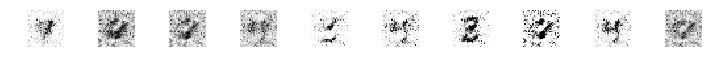

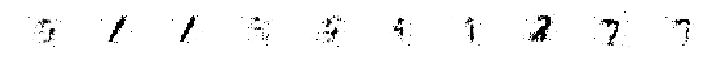

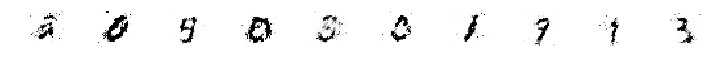

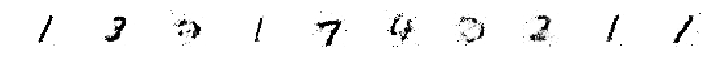

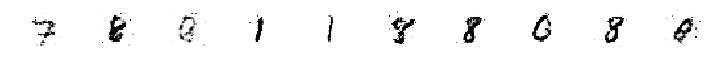

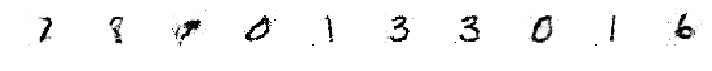

In [13]:
# --------- Helper function for plotting the images generated during training ----------

def plotGeneratedImages(generatedImages, epoch, dim=(1, 10), figsize=(10, 10)):
    title = str(epoch)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.tight_layout
        plt.axis('off')
    plt.tight_layout()
    
for j in range(len(generated_images)):
    plotGeneratedImages(generated_images[j],j)

It is also instructive to look at the generator loss and the discriminator loss through time.

As the discriminator improves, the generator gets better, which then makes the discriminators job harder, and on and on, eventually improving the generator, as desired :)

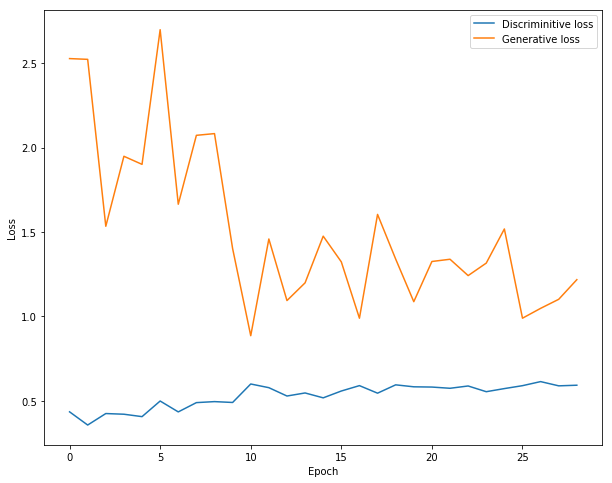

In [21]:
_ = plt.figure(figsize=(10, 8))
_ = plt.plot(discriminator_losses, label='Discriminitive loss')
_ = plt.plot(generator_losses, label='Generative loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend()

#### 3) Some outlook:

Many people are doing very cool things with GAN's - one of the most interesting is generating data from conditional probability distributions:

<center><img src="images/conditional_gans.png",width=400,height=400><center>

See the [GAN Zoo](https://github.com/hindupuravinash/the-gan-zoo)!